In [1]:
import numpy as np
import arviz as az
import pandas as pd
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata

from pp_mix.interface import estimate_density_seq
from pp_mix.params_helper import make_default_strauss
import pp_mix.protos.py.params_pb2 as params_pb2

from pp_mix.state import extract_chain
from pp_mix.interface import ConditionalMCMC, estimate_density_seq, simulate_strauss2d
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params

In [2]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
data = pd.read_csv("data/add_health_extended.csv", sep=" ")
data.head()

,Lied,Public_loud,Damaged_pro,Stolen_S,Stolen_50,Group_f
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0


In [3]:
len(data)

6533

### Setting HyperParams

In [26]:
prec_params = params_pb2.GammaParams(alpha=1, beta=1)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=5)


strauss_params = params_pb2.StraussParams()
strauss_params.init.R = 0.3
strauss_params.init.gamma = 1e-30
strauss_params.init.beta = 0.01
strauss_params.fixed_params = True

sampler = ConditionalMCMC(pp_params=strauss_params, 
                          prec_params=prec_params,
                          jump_params=gamma_jump_params,
                          mala_stepsize=0.00001)

sampler.run(100000, 20000, 10, data.to_numpy(), bernoulli=True)

Burnin, iter # 200  /  100000
Burnin, iter # 400  /  100000
Burnin, iter # 600  /  100000
Burnin, iter # 800  /  100000
Burnin, iter # 1000  /  100000
Burnin, iter # 1200  /  100000
Burnin, iter # 1400  /  100000
Burnin, iter # 1600  /  100000
Burnin, iter # 1800  /  100000
Burnin, iter # 2000  /  100000
Burnin, iter # 2200  /  100000
Burnin, iter # 2400  /  100000
Burnin, iter # 2600  /  100000
Burnin, iter # 2800  /  100000
Burnin, iter # 3000  /  100000
Burnin, iter # 3200  /  100000
Burnin, iter # 3400  /  100000
Burnin, iter # 3600  /  100000
Burnin, iter # 3800  /  100000
Burnin, iter # 4000  /  100000
Burnin, iter # 4200  /  100000
Burnin, iter # 4400  /  100000
Burnin, iter # 4600  /  100000
Burnin, iter # 4800  /  100000
Burnin, iter # 5000  /  100000
Burnin, iter # 5200  /  100000
Burnin, iter # 5400  /  100000
Burnin, iter # 5600  /  100000
Burnin, iter # 5800  /  100000
Burnin, iter # 6000  /  100000
Burnin, iter # 6200  /  100000
Burnin, iter # 6400  /  100000
Burnin, iter

Burnin, iter # 51800  /  100000
Burnin, iter # 52000  /  100000
Burnin, iter # 52200  /  100000
Burnin, iter # 52400  /  100000
Burnin, iter # 52600  /  100000
Burnin, iter # 52800  /  100000
Burnin, iter # 53000  /  100000
Burnin, iter # 53200  /  100000
Burnin, iter # 53400  /  100000
Burnin, iter # 53600  /  100000
Burnin, iter # 53800  /  100000
Burnin, iter # 54000  /  100000
Burnin, iter # 54200  /  100000
Burnin, iter # 54400  /  100000
Burnin, iter # 54600  /  100000
Burnin, iter # 54800  /  100000
Burnin, iter # 55000  /  100000
Burnin, iter # 55200  /  100000
Burnin, iter # 55400  /  100000
Burnin, iter # 55600  /  100000
Burnin, iter # 55800  /  100000
Burnin, iter # 56000  /  100000
Burnin, iter # 56200  /  100000
Burnin, iter # 56400  /  100000
Burnin, iter # 56600  /  100000
Burnin, iter # 56800  /  100000
Burnin, iter # 57000  /  100000
Burnin, iter # 57200  /  100000
Burnin, iter # 57400  /  100000
Burnin, iter # 57600  /  100000
Burnin, iter # 57800  /  100000
Burnin, 

Running, iter # 3200  /  20000
Running, iter # 3400  /  20000
Running, iter # 3600  /  20000
Running, iter # 3800  /  20000
Running, iter # 4000  /  20000
Running, iter # 4200  /  20000
Running, iter # 4400  /  20000
Running, iter # 4600  /  20000
Running, iter # 4800  /  20000
Running, iter # 5000  /  20000
Running, iter # 5200  /  20000
Running, iter # 5400  /  20000
Running, iter # 5600  /  20000
Running, iter # 5800  /  20000
Running, iter # 6000  /  20000
Running, iter # 6200  /  20000
Running, iter # 6400  /  20000
Running, iter # 6600  /  20000
Running, iter # 6800  /  20000
Running, iter # 7000  /  20000
Running, iter # 7200  /  20000
Running, iter # 7400  /  20000
Running, iter # 7600  /  20000
Running, iter # 7800  /  20000
Running, iter # 8000  /  20000
Running, iter # 8200  /  20000
Running, iter # 8400  /  20000
Running, iter # 8600  /  20000
Running, iter # 8800  /  20000
Running, iter # 9000  /  20000
Running, iter # 9200  /  20000
Running, iter # 9400  /  20000
Running,

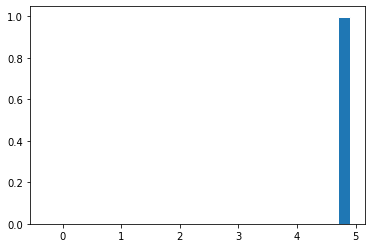

In [30]:
ma_chain = np.array([len(x.a_means) for x in sampler.chains])
width = 0.2
bars = np.arange(max(np.max(ma_chain), 6))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

plt.show()

In [40]:
sampler.serialize_chains("data/latent_class_chains_1707.recordio")

In [ ]:
sampler.chains[-1].clus_alloc

## Loading Chains

In [4]:
chains = loadChains("data/latent_class_chains_1707.recordio", MultivariateMixtureState)

In [5]:
clus_allocs = np.vstack([np.array(x.clus_alloc) for x in chains]).astype(np.int32)

In [6]:
np.savetxt("data/latent_class_allocs.csv", clus_allocs, delimiter=", ", fmt="%d")

In [7]:
## read best
import pandas as pd

best_clus = pd.read_csv("data/best_clus_latent.csv", sep=",")["x"].values - 1

In [11]:
np.unique(best_clus)

array([0, 1, 2, 3, 4])

In [12]:
data = pd.read_csv("data/add_health_extended.csv", sep=" ")
data.head()

,Lied,Public_loud,Damaged_pro,Stolen_S,Stolen_50,Group_f
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0


In [13]:
# compute estimates
theta_chains = np.zeros((len(chains), len(data), chains[0].a_means[0].size))
for i, state in enumerate(chains):
    clus_alloc = np.array(state.clus_alloc)
    for k in np.unique(clus_alloc):
        wh = np.where(clus_alloc == k)[0]
        theta_chains[i, wh, :] = to_numpy(state.a_means[k])

In [14]:
theta_hats = []
emp_freqs = []
weights = []
for k in np.unique(best_clus):
    wh = np.where(best_clus == k)[0]
    theta_hats.append(np.mean(theta_chains[:, wh, :], axis=(0, 1)))
    emp_freqs.append(np.mean(data.iloc[wh].values, axis=0))
    weights.append(len(wh) / len(data))

In [15]:
weights

[0.593448645339048,
 0.09444359406092148,
 0.030460737792744528,
 0.10133170059696923,
 0.18031532221031685]

0 0.593448645339048
4 0.18031532221031685
3 0.10133170059696923
1 0.09444359406092148
2 0.030460737792744528


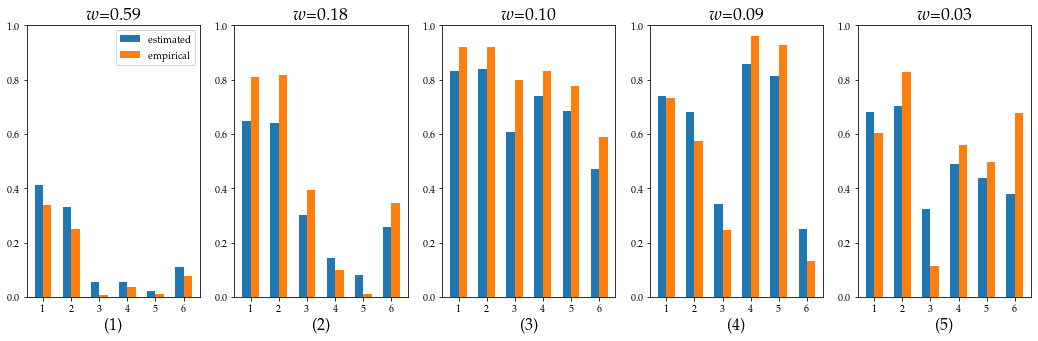

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=len(weights), figsize=(18, 5))

for k in range(len(weights)):
    i = np.argsort(weights)[::-1][k]
    print(i, weights[i])
    axes[k].bar(np.arange(6) - 0.15, theta_hats[i], width=0.3, label="estimated")
    axes[k].bar(np.arange(6) + 0.15, emp_freqs[i], width=0.3, label="empirical")
    axes[k].set_title("$w$={0:.2f}".format(weights[i]), fontsize=18)
    axes[k].set_ylim((0, 1))
    axes[k].set_xticks(np.arange(6))
    axes[k].set_xticklabels(np.arange(6) + 1)
    axes[k].set_xlabel("({0})".format(k+1), fontsize=16)
    
axes[0].legend()
# plt.savefig("images/latent_class_tau.pdf", bbox_inches='tight')
plt.show()

In [19]:
neworder = np.argsort(weights)[::-1]

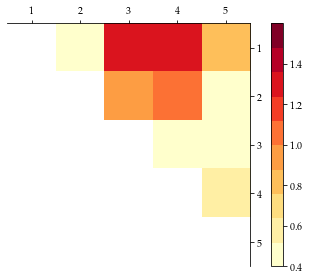

In [27]:
import matplotlib
from sklearn.metrics import pairwise_distances
from matplotlib import ticker

fig, ax = plt.subplots()

params = {"xtick.labelbottom": False, 'xtick.labeltop': True}

dists = pairwise_distances(np.vstack(theta_hats))

dists = dists[neworder, :][:, neworder]

mask =  np.tri(dists.shape[0], k=0)
A = np.ma.array(dists, mask=mask)
cmap = matplotlib.cm.get_cmap('YlOrRd', 10) # jet doesn't have white color
cmap.set_bad('w')
cax = plt.imshow(A, cmap=cmap, vmin=0.4, vmax=1.6, origin="upper")

ax.xaxis.tick_top()
ax.yaxis.tick_right()

ax.set_xticklabels(np.arange(0, 6))
ax.set_yticklabels(np.arange(0, 6))

# plt.xticks([])
# plt.yticks([])

# ax.set_xticklabels(np.arange(0, 6))
# ax.set_yticklabels(np.arange(0, 6))

# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.tick_params(axis='both', which='both')
# ax.tick_params(axis='x', which='both', labelbottom='off', labeltop='on')
# ax.tick_params(axis='both', pad=1)
# plt.tick_params(top='on', bottom='off', left='off', right='on', labelleft='off', labelbottom="off") # 

ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

cbar = fig.colorbar(cax, ticks=[0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
plt.tight_layout()
plt.savefig("images/tau_pdist.pdf")
plt.show()

In [23]:
neworder

array([0, 4, 3, 1, 2])

In [25]:
dists[neworder, :][:, neworder]

array([[0.        , 0.4949156 , 1.33169849, 1.26554444, 0.84468336],
       [0.4949156 , 0.        , 0.96266114, 1.02614801, 0.51346464],
       [1.33169849, 0.96266114, 0.        , 0.42597324, 0.50440913],
       [1.26554444, 1.02614801, 0.42597324, 0.        , 0.5462926 ],
       [0.84468336, 0.51346464, 0.50440913, 0.5462926 , 0.        ]])